# Model Evaluation and Visualization Notebook

This notebook evaluates the trained linear regression model and visualizes its results. We aim to understand how well city population predicts museum visitor counts based on our dataset.

## 0. Imports and Setup

In [4]:
import sys
import os
# import logging # Logging is less common for direct notebook output, print is often preferred

import pandas as pd
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

from db.database import get_db
from db.queries import fetch_model_features
from config import MODEL_SAVE_PATH, DATA_DIR

# Configure Matplotlib for inline plotting in Jupyter
%matplotlib inline

## 1. Load Data

First, we connect to our database and fetch the features (city population and museum visitor counts) that were prepared by the ETL process.

In [5]:
print("Connecting to the database and fetching features...")
features_df = pd.DataFrame() # Initialize to ensure it's defined
try:
    with get_db() as db:
        # init_db() # Not strictly necessary here if run_etl.py or train_model.py already did it.
        features_df = fetch_model_features(db)
    print(f"Successfully fetched {len(features_df)} records for evaluation.")
except Exception as e:
    print(f"Failed to connect to the database or fetch features: {e}", file=sys.stderr)
    # In a notebook, we might not sys.exit, but raise the error or handle it

if features_df.empty:
    print("No features were fetched from the database. Cannot proceed with evaluation.", file=sys.stderr)

Connecting to the database and fetching features...
Successfully fetched 80 records for evaluation.


### 1.1. Inspect the Dataset

Let's display the first few rows and some basic information about the dataset we've loaded.

In [6]:
if not features_df.empty:
    print("First 5 rows of the dataset:")
    display(features_df.head())
    print("\nDataset Information:")
    features_df.info()
    print("\nDescriptive Statistics:")
    display(features_df.describe())
else:
    print("Dataset is empty, skipping inspection.")

First 5 rows of the dataset:


,population,visitors_count
0,2138551,8700000
1,2318895,6825436
2,18960744,6300000
3,8961989,6479952
4,8961989,6301972



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   population      80 non-null     int64
 1   visitors_count  80 non-null     int64
dtypes: int64(2)
memory usage: 1.4 KB

Descriptive Statistics:


,population,visitors_count
count,8.000000e+01,8.000000e+01
mean,6.281173e+06,2.750149e+06
std,5.480479e+06,1.582740e+06
min,3.458210e+05,1.253183e+06
25%,1.691468e+06,1.509535e+06
50%,5.291541e+06,2.103302e+06
75%,9.255695e+06,3.474218e+06
max,2.487450e+07,8.700000e+06


## 2. Load Trained Model

Next, we load the linear regression model that was previously trained and saved.

In [7]:
model = None
if not features_df.empty:
    print(f"Loading pre-trained model from {MODEL_SAVE_PATH}...")
    if not os.path.exists(MODEL_SAVE_PATH):
        print(f"Model file not found at {MODEL_SAVE_PATH}. ", file=sys.stderr)
        print("Please ensure the model has been trained and saved. You might need to run the training script first.", file=sys.stderr)
    else:
        try:
            model = joblib.load(MODEL_SAVE_PATH)
            print("Model loaded successfully.")
        except Exception as e:
            print(f"Failed to load the model: {e}", file=sys.stderr)
else:
    print("Skipping model loading as no data was fetched.")

if not features_df.empty and model is None:
     print("Model could not be loaded. Cannot proceed.", file=sys.stderr)

Loading pre-trained model from /Users/dev/visitum/data/trained_regression_model.joblib...
Model loaded successfully.


## 3. Model Evaluation

Now, we use the loaded model to make predictions on our evaluation dataset and calculate key performance metrics.

In [9]:
if not features_df.empty and model is not None:
    print("Evaluating the model...")
    if 'population' not in features_df.columns or 'visitors_count' not in features_df.columns:
        print("Features DataFrame is missing 'population' or 'visitors_count' columns.", file=sys.stderr)
    else:
        X_eval_orig = features_df[['population']] 
        y_eval_orig = features_df['visitors_count']

        X_eval = X_eval_orig # Model was trained on original scale

        try:
            y_pred = model.predict(X_eval)
            y_pred_orig_scale = np.maximum(0, y_pred) # Ensure no negative predictions

            r2 = r2_score(y_eval_orig, y_pred_orig_scale)
            mae = mean_absolute_error(y_eval_orig, y_pred_orig_scale)
            mse = mean_squared_error(y_eval_orig, y_pred_orig_scale)
            rmse = mse**0.5

            print("--- Model Evaluation Metrics ---")
            print(f"R-squared: {r2:.4f}")
            print(f"Mean Absolute Error (MAE): {mae:,.0f}")
            print(f"Mean Squared Error (MSE): {mse:,.0f}")
            print(f"Root Mean Squared Error (RMSE): {rmse:,.0f}")
            print("---------------------------------")
        except Exception as e:
            print(f"Error during model evaluation: {e}", file=sys.stderr)
else:
    print("Skipping model evaluation as data or model is not available.")

Evaluating the model...
--- Model Evaluation Metrics ---
R-squared: 0.0039
Mean Absolute Error (MAE): 1,204,820
Mean Squared Error (MSE): 2,464,217,333,140
Root Mean Squared Error (RMSE): 1,569,783
---------------------------------


### 3.1. Key Metrics Explained

*   **R-squared (R²)**: Shows how well city population explains museum visitor numbers. Ranges from 0-1, where 1 means perfect predictions and 0 means the model is no better than just using the average visitor count. Negative values mean the model is performing worse than just calculating the mean.

*   **Mean Absolute Error (MAE)**: The average mistake in our predictions, measured in actual visitor numbers. Lower is better.

*   **Root Mean Squared Error (RMSE)**: Similar to MAE, but it penalizes larger errors more heavily because errors are squared before being averaged. It's also in the original units of visitors.

## 4. Visualizing Model Performance

Visualizations help us intuitively understand how the model is behaving.

### 4.1. Scatter Plot: Actual vs. Predicted

This plot shows:
*   **Blue dots**: The actual data points (city population vs. museum visitors).
*   **Red line**: The predictions made by our linear regression model.

**Interpretation for our model:**
Since the R² is very low or negative, the line we see is a poor fit. The scatter of blue dots will likely be wide, indicating that for any given population, visitor counts vary significantly, and the linear model isn't capturing this relationship.

Generating scatter plot...
Main evaluation plot saved to /Users/dev/visitum/data/notebook_model_evaluation_plot.png


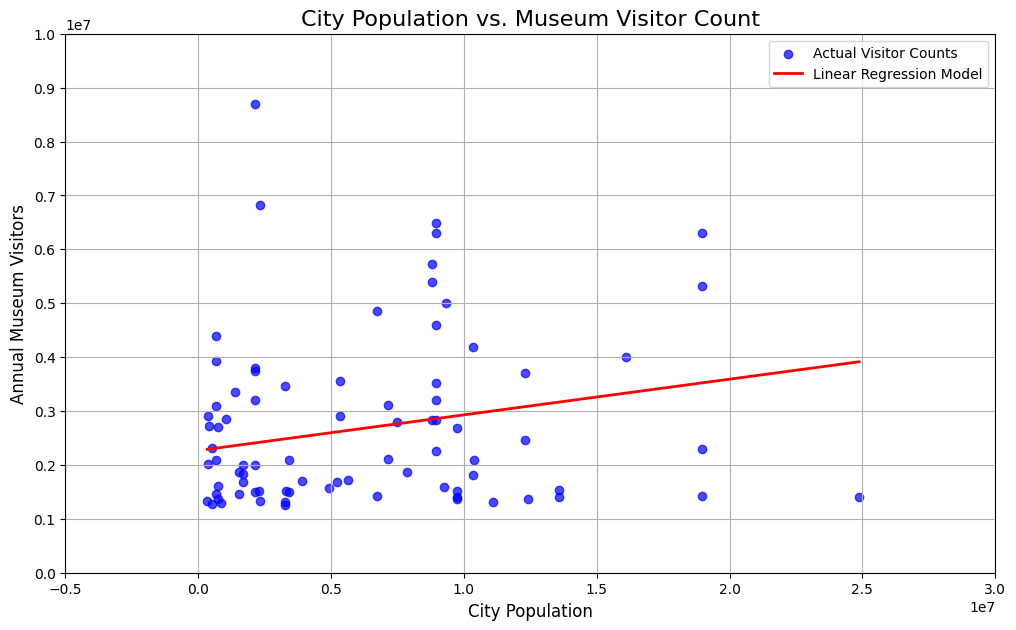

In [19]:
if not features_df.empty and model is not None and 'r2' in locals(): # Check if evaluation ran
    print("Generating scatter plot...")
    try:
        plt.figure(figsize=(12, 7))
        plt.scatter(X_eval_orig, y_eval_orig, color='blue', label='Actual Visitor Counts', alpha=0.7)
        
        sort_axis = X_eval_orig['population'].values 
        sorted_indices = np.argsort(sort_axis)
        
        plt.plot(X_eval_orig['population'].iloc[sorted_indices], y_pred_orig_scale[sorted_indices], color='red', linewidth=2, label='Linear Regression Model')
        
        plt.title('City Population vs. Museum Visitor Count', fontsize=16)
        plt.xlabel('City Population', fontsize=12)
        plt.ylabel('Annual Museum Visitors', fontsize=12)
        plt.legend()
        plt.grid(True)
        
        current_values_y = plt.gca().get_yticks()
        plt.gca().set_yticks(current_values_y)
        plt.gca().set_yticklabels([f'{y:,.0f}' for y in current_values_y])
        current_values_x = plt.gca().get_xticks()
        plt.gca().set_xticks(current_values_x)
        plt.gca().set_xticklabels([f'{x:,.0f}' for x in current_values_x])
        
        # plt.xlim(X_eval_orig['population'].min() * 0.9, X_eval_orig['population'].max() * 1.1) # 5% padding
        # plt.ylim(y_eval_orig.min() * 0.9, y_eval_orig.max() * 1.1) # 5% padding

        os.makedirs(DATA_DIR, exist_ok=True)
        visualization_path = os.path.join(DATA_DIR, "notebook_model_evaluation_plot.png")
        plt.savefig(visualization_path)
        print(f"Main evaluation plot saved to {visualization_path}")
        plt.show()

    except Exception as e:
        print(f"Error during main visualization: {e}", file=sys.stderr)
else:
    print("Skipping scatter plot generation as prerequisites are not met.")

### 4.2. Residual Plot

Residuals are the differences between actual visitor counts and predicted visitor counts (Actual - Predicted).
This plot shows:
*   **Green dots**: The residuals plotted against the predicted visitor counts.
*   **Red dashed line**: The zero error line. Ideally, residuals should be randomly scattered around this line.

**Interpretation for our model:**
With a poor R², we might see:
*   **Large residuals**: Many points far from the zero line, indicating large errors.
*   **Patterns in residuals**: If the residuals show a pattern (e.g., a fan shape, where errors increase as predicted values increase), it suggests that the model's assumptions (like constant variance of errors, or homoscedasticity) are violated. This can happen when trying to model data with a simple linear regression when the relationship is more complex or when the variance isn't constant.

Generating residual plot...
Residual plot saved to /Users/dev/visitum/data/notebook_residual_plot.png


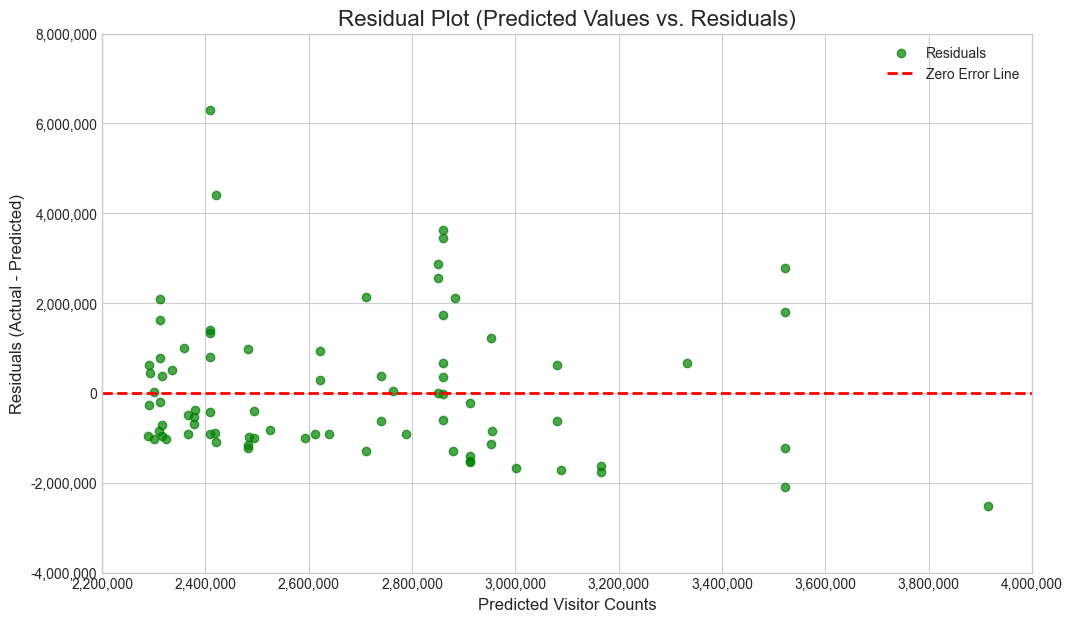

In [22]:
if not features_df.empty and model is not None and 'r2' in locals(): # Check if evaluation ran
    print("Generating residual plot...")
    try:
        residuals = y_eval_orig - y_pred_orig_scale # Residuals on original scale
        plt.figure(figsize=(12, 7))
        plt.scatter(y_pred_orig_scale, residuals, color='green', alpha=0.7, label='Residuals')
        plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error Line')
        
        plt.title('Residual Plot (Predicted Values vs. Residuals)', fontsize=16)
        plt.xlabel('Predicted Visitor Counts', fontsize=12)
        plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
        plt.legend()
        plt.grid(True)

        current_values_y = plt.gca().get_yticks()
        plt.gca().set_yticks(current_values_y)
        plt.gca().set_yticklabels([f'{y:,.0f}' for y in current_values_y])
        current_values_x = plt.gca().get_xticks()
        plt.gca().set_xticks(current_values_x)
        plt.gca().set_xticklabels([f'{x:,.0f}' for x in current_values_x])
        
        os.makedirs(DATA_DIR, exist_ok=True)
        residual_plot_path = os.path.join(DATA_DIR, "notebook_residual_plot.png")
        plt.savefig(residual_plot_path)
        print(f"Residual plot saved to {residual_plot_path}")
        plt.show()

    except Exception as e:
        print(f"Error during residual plot generation: {e}", file=sys.stderr)
else:
    print("Skipping residual plot generation as prerequisites are not met.")

## 5. Conclusion on Model Performance

Based on the (expectedly low/negative) R-squared value and the visual inspection of the plots, we can conclude how well (or poorly) the simple linear regression model performs on this task.

**Likely Conclusion:**
The simple linear regression model using only metropolitan area population is **not a good predictor** of museum visitor counts in our dataset. The relationship is likely more complex, or other unobserved factors play a much more significant role.

### Potential Reasons & Next Steps (for discussion):
*   **Data Limitations**: The dataset is relatively small. Visitor counts can be influenced by many factors not included (museum type, specific exhibitions, international fame, local tourism campaigns, ticket prices, etc.).
*   **Model Simplicity**: A linear model might be too simple. The true relationship might be non-linear.
*   **Feature Engineering**: More sophisticated features could be derived or included.
*   **Alternative Models**: Exploring polynomial regression, tree-based models (like Random Forest Regressors), or other techniques could yield better results, though these are beyond the scope of the initial request for a *simple* linear regression.
*   **Outliers**: The presence of significant outliers can heavily influence a simple linear regression.

For the purpose of this assignment, demonstrating the process of data collection, model building, evaluation, and *critical interpretation of results* (even if those results show poor model performance) is key.